In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report, recall_score, precision_score, confusion_matrix, f1_score
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from vecstack import stacking

In [3]:
!pip install scikit-plot

In [4]:
conda install -c conda-forge xgboost

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install vecstack

In [6]:
data=pd.read_csv('Churn_Modelling.csv')
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [7]:
data.shape

(10000, 14)

In [8]:
#data description
def understand_data(data) :
    return(pd.DataFrame({"Datatype":data.dtypes,
                         "No of NAs":data.isna().sum(),
                         "No of Levels":data.apply(lambda x: x.nunique(),axis=0),
                         "Levels":data.apply(lambda x: str(x.unique()),axis=0)}))

In [9]:
understand_data(data)

,Datatype,No of NAs,No of Levels,Levels
RowNumber,int64,0,10000,[ 1 2 3 ... 9998 9999 10000]
CustomerId,int64,0,10000,[15634602 15647311 15619304 ... 15584532 15682...
Surname,object,0,2932,['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Ald...
CreditScore,int64,0,460,[619 608 502 699 850 645 822 376 501 684 528 4...
Geography,object,0,3,['France' 'Spain' 'Germany']
Gender,object,0,2,['Female' 'Male']
Age,int64,0,70,[42 41 39 43 44 50 29 27 31 24 34 25 35 45 58 ...
Tenure,int64,0,11,[ 2 1 8 7 4 6 3 10 5 9 0]
Balance,float64,0,6382,[ 0. 83807.86 159660.8 ... 57369.61 ...
NumOfProducts,int64,0,4,[1 3 2 4]


In [10]:
#creating seperate column types
cat_cols=['Geography','Gender','Tenure','HasCrCard','IsActiveMember','Exited']
num_cols=['CreditScore','Balance','Age','NumOfProducts','EstimatedSalary']

In [11]:
for col in cat_cols:
    data[col]=data[col].astype('category')

In [12]:
data.dtypes

RowNumber             int64
CustomerId            int64
Surname              object
CreditScore           int64
Geography          category
Gender             category
Age                   int64
Tenure             category
Balance             float64
NumOfProducts         int64
HasCrCard          category
IsActiveMember     category
EstimatedSalary     float64
Exited             category
dtype: object

In [10]:
data.Surname.value_counts()

Smith             32
Martin            29
Scott             29
Walker            28
Brown             26
                  ..
Lassetter          1
Vanmeter           1
Denman             1
Hayes-Williams     1
Krichauff          1
Name: Surname, Length: 2932, dtype: int64

Removing customer id , row number and Surname column:

In [13]:
data.drop(labels=['RowNumber','CustomerId','Surname'], axis=1,inplace=True)
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [14]:
data.Balance.value_counts()

0.00         3617
105473.74       2
130170.82       2
72594.00        1
139723.90       1
             ... 
130306.49       1
92895.56        1
132005.77       1
166287.85       1
104001.38       1
Name: Balance, Length: 6382, dtype: int64

In [13]:
#converting 0s of balance to NAs
data.Balance[data.Balance==0]=np.NaN

<ipython-input-13-9870dab50069>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Balance[data.Balance==0]=np.NaN


In [15]:
data.Balance.isna().sum()

0

In [16]:
X=data.drop(['Exited'],axis=1)
y=data.Exited
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8,random_state=123,stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state=123,stratify=y_rem)

In [17]:
shape=[X_train,X_valid, X_test, y_train,y_valid, y_test]
for i in shape:
    print(i.shape)

(8000, 10)
(1000, 10)
(1000, 10)
(8000,)
(1000,)
(1000,)


In [18]:
prop=[y_train,y_test,y_valid]
for i in prop:
    print(i.value_counts(normalize=True)*100)

0    79.625
1    20.375
Name: Exited, dtype: float64
0    79.7
1    20.3
Name: Exited, dtype: float64
0    79.6
1    20.4
Name: Exited, dtype: float64


In [19]:
understand_data(data)

,Datatype,No of NAs,No of Levels,Levels
CreditScore,int64,0,460,[619 608 502 699 850 645 822 376 501 684 528 4...
Geography,category,0,3,"['France', 'Spain', 'Germany']\nCategories (3,..."
Gender,category,0,2,"['Female', 'Male']\nCategories (2, object): ['..."
Age,int64,0,70,[42 41 39 43 44 50 29 27 31 24 34 25 35 45 58 ...
Tenure,category,0,11,"[2, 1, 8, 7, 4, ..., 3, 10, 5, 9, 0]\nLength: ..."
Balance,float64,0,6382,[ 0. 83807.86 159660.8 ... 57369.61 ...
NumOfProducts,int64,0,4,[1 3 2 4]
HasCrCard,category,0,2,"[1, 0]\nCategories (2, int64): [1, 0]"
IsActiveMember,category,0,2,"[1, 0]\nCategories (2, int64): [1, 0]"
EstimatedSalary,float64,0,9999,[101348.88 112542.58 113931.57 ... 42085.58 ...


In [19]:
data.isna().sum()

CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance            3617
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
dtype: int64

In [20]:
cat_cols1=['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
mapper = DataFrameMapper(
    [([continuous_col],[SimpleImputer(strategy='mean'),StandardScaler()])for continuous_col in num_cols]+
    [([categorical_col],OneHotEncoder())for categorical_col in cat_cols1]
    ,df_out=True)
mapper.fit(X_train)

DataFrameMapper(df_out=True, drop_cols=[],
                features=[(['CreditScore'],
                           [SimpleImputer(), StandardScaler()]),
                          (['Balance'], [SimpleImputer(), StandardScaler()]),
                          (['Age'], [SimpleImputer(), StandardScaler()]),
                          (['NumOfProducts'],
                           [SimpleImputer(), StandardScaler()]),
                          (['EstimatedSalary'],
                           [SimpleImputer(), StandardScaler()]),
                          (['Geography'], OneHotEncoder()),
                          (['Gender'], OneHotEncoder()),
                          (['Tenure'], OneHotEncoder()),
                          (['HasCrCard'], OneHotEncoder()),
                          (['IsActiveMember'], OneHotEncoder())])

In [21]:
X_train_std=mapper.transform(X_train)
X_test_std=mapper.transform(X_test)
X_valid_std=mapper.transform(X_valid)

In [22]:
scores = pd.DataFrame(columns=['Model','Train_Accuracy','Train_Recall','Train_Precision','Train_F1_Score','Test_Accuracy','Test_Recall','Test_Precision','Test_F1_Score'])

def get_metrics(train_actual,train_predicted,test_actual,test_predicted,model_description,dataframe):
    train_accuracy = accuracy_score(train_actual,train_predicted)
    train_recall   = recall_score(train_actual,train_predicted)
    train_precision= precision_score(train_actual,train_predicted)
    train_f1score  = f1_score(train_actual,train_predicted)
    test_accuracy = accuracy_score(test_actual,test_predicted)
    test_recall   = recall_score(test_actual,test_predicted)
    test_precision= precision_score(test_actual,test_predicted)
    test_f1score  = f1_score(test_actual,test_predicted)
    dataframe = dataframe.append(pd.Series([model_description, train_accuracy,train_recall,train_precision,train_f1score,
                                            test_accuracy,test_recall,test_precision,test_f1score],
                                           index=scores.columns ), ignore_index=True)
    return(dataframe)

In [23]:
dt_log=LogisticRegressionCV(n_jobs=-1,class_weight='balanced')
dt_log.fit(X_train_std,y_train)

LogisticRegressionCV(class_weight='balanced', n_jobs=-1)

In [24]:
y_pred_train = dt_log.predict(X_train_std)
y_pred_test = dt_log.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"LogisticRegression",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.72275,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245


In [25]:
dt_DT=DecisionTreeClassifier(max_depth=4,class_weight='balanced')
dt_DT.fit(X_train_std,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4)

In [26]:
y_pred_train = dt_DT.predict(X_train_std)
y_pred_test = dt_DT.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"Decision trees",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.72275,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.75625,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524


In [27]:
param_grid={"criterion":['gini', 'entropy'],"max_depth":[3,4,5,6,7,8],'min_samples_split':[4,5,6,7,8,9]}
dt_DT_gs=GridSearchCV(dt_DT,param_grid=param_grid,n_jobs=-1,cv=10)
%time dt_DT_gs.fit(X_train_std,y_train)

Wall time: 7.09 s


GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              max_depth=4),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_samples_split': [4, 5, 6, 7, 8, 9]})

In [33]:
dt_DT_gs=dt_DT_gs.best_estimator_

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5}

In [28]:
y_pred_train = dt_DT_gs.predict(X_train_std)
y_pred_test = dt_DT_gs.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"Decision trees_GS",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.72275,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.75625,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.83475,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667


In [29]:
#building SVM model
dt_SVM=SVC(kernel='linear', C=1,class_weight='balanced')
dt_SVM.fit(X_train_std,y_train)

SVC(C=1, class_weight='balanced', kernel='linear')

In [30]:
y_pred_train = dt_SVM.predict(X_train_std)
y_pred_test = dt_SVM.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"SVM Model",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192


In [31]:
param_grid={'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.4,0.5,1],'gamma':['scale','auto']}
dt_SVM_gs=GridSearchCV(dt_SVM,param_grid=param_grid,n_jobs=-1,cv=10)

In [33]:
%time dt_SVM_gs.fit(X_train_std,y_train)

Wall time: 5min 55s


GridSearchCV(cv=10,
             estimator=SVC(C=1, class_weight='balanced', kernel='linear'),
             n_jobs=-1,
             param_grid={'C': [0.4, 0.5, 1], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [34]:
dt_SVM_gs=dt_SVM_gs.best_estimator_

In [35]:
y_pred_train = dt_SVM_gs.predict(X_train_std)
y_pred_test = dt_SVM_gs.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"SVM Model_GS",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192
4,SVM Model_GS,0.820000,0.699387,0.545455,0.612903,0.806,0.640394,0.517928,0.572687


In [36]:
dt_knn=KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
dt_knn.fit(X_train_std,y_train)

KNeighborsClassifier(n_jobs=-1)

In [37]:
y_pred_train = dt_knn.predict(X_train_std)
y_pred_test = dt_knn.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"KNN",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192
4,SVM Model_GS,0.820000,0.699387,0.545455,0.612903,0.806,0.640394,0.517928,0.572687
5,KNN,0.877875,0.532515,0.801477,0.639882,0.832,0.448276,0.619048,0.520000


In [72]:
param_grid={'n_neighbors':[4,5,6,7,8],'metric':['minkowski','euclidean','manhattan'],'p':[2,3,4],'weights':['uniform','distance']}
dt_knn_gs=GridSearchCV(dt_knn,param_grid=param_grid,n_jobs=-1,cv=10)
%time dt_knn_gs.fit(X_train_std,y_train)

Wall time: 3min 8s


GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [4, 5, 6, 7, 8], 'p': [2, 3, 4],
                         'weights': ['uniform', 'distance']})

In [73]:
dt_knn_gs=dt_knn_gs.best_estimator_

In [74]:
y_pred_train = dt_knn_gs.predict(X_train_std)
y_pred_test = dt_knn_gs.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"KNN__GS",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192
4,SVM Model_GS,0.820000,0.699387,0.545455,0.612903,0.806,0.640394,0.517928,0.572687
5,KNN,0.877875,0.532515,0.801477,0.639882,0.832,0.448276,0.619048,0.520000
6,RandomForests,0.999875,0.999387,1.000000,0.999693,0.857,0.423645,0.767857,0.546032
7,RandomForests_GS,0.838750,0.757669,0.579812,0.656915,0.816,0.679803,0.536965,0.600000
8,AdaBoost,0.861375,0.471166,0.756650,0.580718,0.859,0.458128,0.750000,0.568807
9,AdaBoost_GS,0.861250,0.478528,0.750000,0.584270,0.854,0.448276,0.728000,0.554878


In [39]:
dt_RF=RandomForestClassifier(n_jobs=-1,class_weight='balanced')
%time dt_RF.fit(X_train_std,y_train)

Wall time: 412 ms


RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [40]:
y_pred_train = dt_RF.predict(X_train_std)
y_pred_test = dt_RF.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"RandomForests",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192
4,SVM Model_GS,0.820000,0.699387,0.545455,0.612903,0.806,0.640394,0.517928,0.572687
5,KNN,0.877875,0.532515,0.801477,0.639882,0.832,0.448276,0.619048,0.520000
6,RandomForests,0.999875,0.999387,1.000000,0.999693,0.857,0.423645,0.767857,0.546032


In [45]:
param_grid = {"n_estimators" : [50,75,100],
              "max_depth" : np.arange(1,8,1),
              "max_features" : [3,4,5],
              "min_samples_leaf" : [1, 2,3,4,5]}
dt_RF_gs=GridSearchCV(dt_RF,param_grid=param_grid,n_jobs=-1)
%time dt_RF_gs.fit(X_train_std,y_train)

Wall time: 2min 33s


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7]),
                         'max_features': [3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'n_estimators': [50, 75, 100]})

In [46]:
dt_RF_gs=dt_RF_gs.best_estimator_

In [47]:
y_pred_train = dt_RF_gs.predict(X_train_std)
y_pred_test = dt_RF_gs.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"RandomForests_GS",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192
4,SVM Model_GS,0.820000,0.699387,0.545455,0.612903,0.806,0.640394,0.517928,0.572687
5,KNN,0.877875,0.532515,0.801477,0.639882,0.832,0.448276,0.619048,0.520000
6,RandomForests,0.999875,0.999387,1.000000,0.999693,0.857,0.423645,0.767857,0.546032
7,RandomForests_GS,0.838750,0.757669,0.579812,0.656915,0.816,0.679803,0.536965,0.600000


In [49]:
dt_AB=AdaBoostClassifier(n_estimators=500,learning_rate=0.3)
dt_AB.fit(X_train_std,y_train)

AdaBoostClassifier(learning_rate=0.3, n_estimators=500)

In [50]:
y_pred_train = dt_AB.predict(X_train_std)
y_pred_test = dt_AB.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"AdaBoost",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192
4,SVM Model_GS,0.820000,0.699387,0.545455,0.612903,0.806,0.640394,0.517928,0.572687
5,KNN,0.877875,0.532515,0.801477,0.639882,0.832,0.448276,0.619048,0.520000
6,RandomForests,0.999875,0.999387,1.000000,0.999693,0.857,0.423645,0.767857,0.546032
7,RandomForests_GS,0.838750,0.757669,0.579812,0.656915,0.816,0.679803,0.536965,0.600000
8,AdaBoost,0.861375,0.471166,0.756650,0.580718,0.859,0.458128,0.750000,0.568807


In [51]:
def classifcation_report_train_test(y_train, y_train_pred, y_test, y_test_pred):

    print('''
            =========================================
               CLASSIFICATION REPORT FOR TRAIN DATA
            =========================================
            ''')
    print(classification_report(y_train, y_train_pred, digits=4))

    print('''
            =========================================
               CLASSIFICATION REPORT FOR TEST DATA
            =========================================
            ''')
    print(classification_report(y_test, y_test_pred, digits=4))

In [52]:
classifcation_report_train_test(y_train,y_pred_train,y_test,y_pred_test)


               CLASSIFICATION REPORT FOR TRAIN DATA
            
              precision    recall  f1-score   support

           0     0.8766    0.9612    0.9170      6370
           1     0.7567    0.4712    0.5807      1630

    accuracy                         0.8614      8000
   macro avg     0.8166    0.7162    0.7488      8000
weighted avg     0.8522    0.8614    0.8485      8000


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8744    0.9611    0.9157       797
           1     0.7500    0.4581    0.5688       203

    accuracy                         0.8590      1000
   macro avg     0.8122    0.7096    0.7423      1000
weighted avg     0.8492    0.8590    0.8453      1000



In [53]:
param_grid = {'n_estimators' : [300,400, 500, 600,700],
              'learning_rate' : [0.2, 0.3, 0.4,0.5,0.6]}
dt_AB_gs=GridSearchCV(dt_AB,param_grid=param_grid,cv=10)
%time dt_AB_gs.fit(X_train_std,y_train)

Wall time: 20min 2s


GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(learning_rate=0.3, n_estimators=500),
             param_grid={'learning_rate': [0.2, 0.3, 0.4, 0.5, 0.6],
                         'n_estimators': [300, 400, 500, 600, 700]})

In [54]:
dt_AB_gs=dt_AB_gs.best_estimator_

In [55]:
y_pred_train = dt_AB_gs.predict(X_train_std)
y_pred_test = dt_AB_gs.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"AdaBoost_GS",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192
4,SVM Model_GS,0.820000,0.699387,0.545455,0.612903,0.806,0.640394,0.517928,0.572687
5,KNN,0.877875,0.532515,0.801477,0.639882,0.832,0.448276,0.619048,0.520000
6,RandomForests,0.999875,0.999387,1.000000,0.999693,0.857,0.423645,0.767857,0.546032
7,RandomForests_GS,0.838750,0.757669,0.579812,0.656915,0.816,0.679803,0.536965,0.600000
8,AdaBoost,0.861375,0.471166,0.756650,0.580718,0.859,0.458128,0.750000,0.568807
9,AdaBoost_GS,0.861250,0.478528,0.750000,0.584270,0.854,0.448276,0.728000,0.554878


In [56]:
#Gradient Boost classifier
dt_GD=GradientBoostingClassifier(n_estimators=50,
                                       learning_rate=0.3,
                                       subsample=0.8)
dt_GD.fit(X_train_std,y_train)

GradientBoostingClassifier(learning_rate=0.3, n_estimators=50, subsample=0.8)

In [57]:
y_pred_train = dt_GD.predict(X_train_std)
y_pred_test = dt_GD.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"GradientBoosting",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192
4,SVM Model_GS,0.820000,0.699387,0.545455,0.612903,0.806,0.640394,0.517928,0.572687
5,KNN,0.877875,0.532515,0.801477,0.639882,0.832,0.448276,0.619048,0.520000
6,RandomForests,0.999875,0.999387,1.000000,0.999693,0.857,0.423645,0.767857,0.546032
7,RandomForests_GS,0.838750,0.757669,0.579812,0.656915,0.816,0.679803,0.536965,0.600000
8,AdaBoost,0.861375,0.471166,0.756650,0.580718,0.859,0.458128,0.750000,0.568807
9,AdaBoost_GS,0.861250,0.478528,0.750000,0.584270,0.854,0.448276,0.728000,0.554878


In [58]:
GBM=GradientBoostingClassifier()
param_grid = { 
           "n_estimators" : [50,100,150],
           "max_depth" : [5, 10],
           "learning_rate" : [0.1,0.2,0.3]}
dt_GD_gs=GridSearchCV(GBM,param_grid=param_grid,cv=10)
%time dt_GD_gs.fit(X_train_std,y_train)

Wall time: 14min 34s


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [5, 10],
                         'n_estimators': [50, 100, 150]})

In [59]:
dt_GD_gs=dt_GD_gs.best_estimator_

In [60]:
y_pred_train = dt_GD_gs.predict(X_train_std)
y_pred_test = dt_GD_gs.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"GradientBoosting_GS",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192
4,SVM Model_GS,0.820000,0.699387,0.545455,0.612903,0.806,0.640394,0.517928,0.572687
5,KNN,0.877875,0.532515,0.801477,0.639882,0.832,0.448276,0.619048,0.520000
6,RandomForests,0.999875,0.999387,1.000000,0.999693,0.857,0.423645,0.767857,0.546032
7,RandomForests_GS,0.838750,0.757669,0.579812,0.656915,0.816,0.679803,0.536965,0.600000
8,AdaBoost,0.861375,0.471166,0.756650,0.580718,0.859,0.458128,0.750000,0.568807
9,AdaBoost_GS,0.861250,0.478528,0.750000,0.584270,0.854,0.448276,0.728000,0.554878


In [61]:
#XG Boost model
dt_XG=XGBClassifier(n_estimators=400, gamma=0.5,learning_rate=0.1)
dt_XG.fit(X_train_std,y_train)

C:\Users\Vishnu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:28] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
y_pred_train = dt_XG.predict(X_train_std)
y_pred_test = dt_XG.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"XGBoost",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192
4,SVM Model_GS,0.820000,0.699387,0.545455,0.612903,0.806,0.640394,0.517928,0.572687
5,KNN,0.877875,0.532515,0.801477,0.639882,0.832,0.448276,0.619048,0.520000
6,RandomForests,0.999875,0.999387,1.000000,0.999693,0.857,0.423645,0.767857,0.546032
7,RandomForests_GS,0.838750,0.757669,0.579812,0.656915,0.816,0.679803,0.536965,0.600000
8,AdaBoost,0.861375,0.471166,0.756650,0.580718,0.859,0.458128,0.750000,0.568807
9,AdaBoost_GS,0.861250,0.478528,0.750000,0.584270,0.854,0.448276,0.728000,0.554878


In [63]:
XGB = XGBClassifier(n_jobs=-1, eval_metric='mlogloss',use_label_encoder=False)
 
# Use a grid over parameters of interest
param_grid = {
     'colsample_bytree': np.linspace(0.6, 0.8, 2),
     'n_estimators':[100,200,300],
     'max_depth': [5,6,7,8,10]
}

dt_XGB_gs = GridSearchCV(estimator=XGB, param_grid=param_grid, cv= 10)
%time dt_XGB_gs.fit(X_train_std,y_train)

Wall time: 6min 39s


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mo...straints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                 

In [64]:
dt_XGB_gs=dt_XGB_gs.best_estimator_

In [65]:
y_pred_train = dt_XGB_gs.predict(X_train_std)
y_pred_test = dt_XGB_gs.predict(X_test_std)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"XGBoost_GS",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192
4,SVM Model_GS,0.820000,0.699387,0.545455,0.612903,0.806,0.640394,0.517928,0.572687
5,KNN,0.877875,0.532515,0.801477,0.639882,0.832,0.448276,0.619048,0.520000
6,RandomForests,0.999875,0.999387,1.000000,0.999693,0.857,0.423645,0.767857,0.546032
7,RandomForests_GS,0.838750,0.757669,0.579812,0.656915,0.816,0.679803,0.536965,0.600000
8,AdaBoost,0.861375,0.471166,0.756650,0.580718,0.859,0.458128,0.750000,0.568807
9,AdaBoost_GS,0.861250,0.478528,0.750000,0.584270,0.854,0.448276,0.728000,0.554878


In [67]:
importances = dt_XGB_gs.feature_importances_
indices = np.argsort(importances)
print(indices)

[13 22 21  5 16 10 17 15 14  0  4 19  9  7 18 12 11 20  8  1 23 24  2  6
  3]


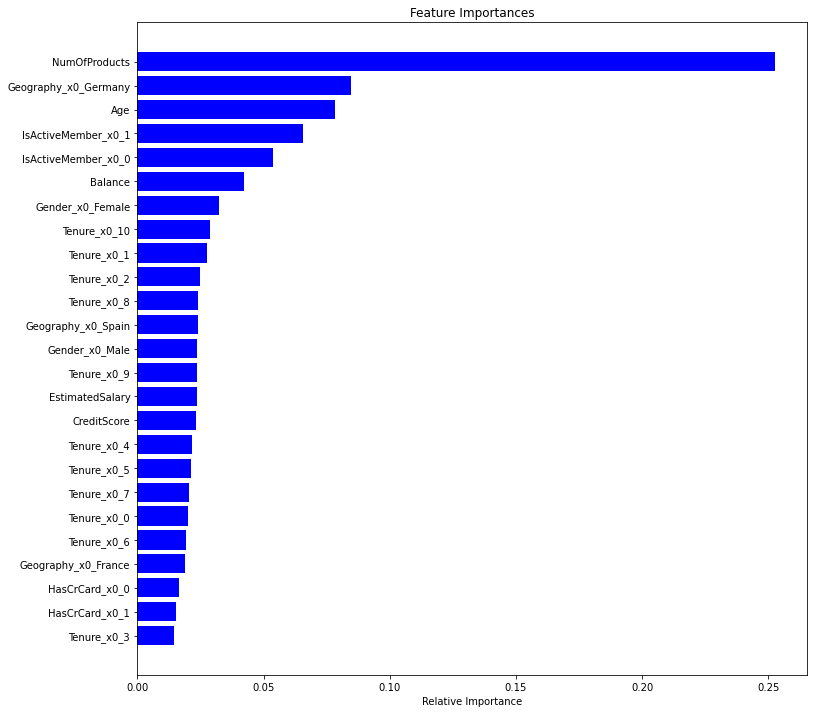

In [68]:
%matplotlib inline
features = X_train_std.columns
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices], color='b',align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize = 10)
plt.xlabel('Relative Importance')

plt.show()

In [69]:
#STACKING Model with out grid search
models=[dt_AB_gs,dt_DT_gs,dt_SVM_gs,dt_GD_gs,dt_knn_gs,dt_log,dt_RF_gs,dt_XGB_gs]

In [75]:
%time
S_train, S_test = stacking(models,                   
                           X_train_std, y_train, X_test_std,   
                           regression=False,  
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)
%time

Wall time: 0 ns
task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [8]

model  0:     [AdaBoostClassifier]
    fold  0:  [0.85850000]
    fold  1:  [0.85050000]
    fold  2:  [0.84850000]
    fold  3:  [0.85150000]
    ----
    MEAN:     [0.85225000] + [0.00376663]
    FULL:     [0.85225000]

model  1:     [GridSearchCV]
    fold  0:  [0.76850000]
    fold  1:  [0.79350000]
    fold  2:  [0.77050000]
    fold  3:  [0.79750000]
    ----
    MEAN:     [0.78250000] + [0.01309580]
    FULL:     [0.78250000]

model  2:     [SVC]
    fold  0:  [0.82800000]
    fold  1:  [0.81650000]
    fold  2:  [0.80850000]
    fold  3:  [0.82000000]
    ----
    MEAN:     [0.81825000] + [0.00700446]
    FULL:     [0.81825000]

model  3:     [GradientBoostingClassifier]
    fold  0:  [0.86250000]
    fold  1:  [0.86200000]
    fold  2:  [0.85700000]
    fold  3:  [0.85850000]
    ----
    MEAN:     [0.86000000] + [0.00231840]
    FULL:

In [76]:
dt_DT_gs.best_params_

{'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 6}

In [77]:
model=DecisionTreeClassifier(criterion='gini',max_depth=8,min_samples_split=6,class_weight='balanced')
%time model.fit(S_train,y_train)

Wall time: 9 ms


DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=6)

In [78]:
y_pred_train=model.predict(S_train)
y_pred_test = model.predict(S_test)
scores = get_metrics(y_train,y_pred_train,y_test,y_pred_test,"Stacking Model",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.722750,0.695706,0.397059,0.505573,0.707,0.674877,0.376374,0.483245
1,Decision trees,0.756250,0.731902,0.440872,0.550277,0.776,0.763547,0.468278,0.580524
2,Decision trees_GS,0.834750,0.779755,0.568935,0.657867,0.777,0.665025,0.465517,0.547667
3,SVM Model,0.723125,0.711043,0.399242,0.511361,0.700,0.645320,0.364903,0.466192
4,SVM Model_GS,0.820000,0.699387,0.545455,0.612903,0.806,0.640394,0.517928,0.572687
5,KNN,0.877875,0.532515,0.801477,0.639882,0.832,0.448276,0.619048,0.520000
6,RandomForests,0.999875,0.999387,1.000000,0.999693,0.857,0.423645,0.767857,0.546032
7,RandomForests_GS,0.838750,0.757669,0.579812,0.656915,0.816,0.679803,0.536965,0.600000
8,AdaBoost,0.861375,0.471166,0.756650,0.580718,0.859,0.458128,0.750000,0.568807
9,AdaBoost_GS,0.861250,0.478528,0.750000,0.584270,0.854,0.448276,0.728000,0.554878
